In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
# sys.path.append("..")
import models.generator_cnn as models
from models.generator import Generator
# from models.discriminator import Discriminator
from models.discriminator_cnn import Discriminator_cnn2
import torchvision
from torchvision4ad.datasets import MVTecAD

In [2]:
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:

            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
device = "cuda" if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize((512, 512)),  # Reduce image size to save memory
    transforms.RandomCrop((256,256)),
    transforms.Normalize([0.5], [0.5]), # normalize image with mean and standard deviation.
])


In [ ]:
lr=0.0002
noise_dim=128
batch_size=32
epochs=50

In [4]:
noise = torch.randn(2, 128, 1, 1)
model = models.Generator_256(128)
output = model(noise)
print(output[0,0].detach())

tensor([[ 0.0815, -0.3950, -0.1767,  ..., -0.3275, -0.0533, -0.4064],
        [-0.3355,  0.2393,  0.2612,  ..., -0.2857,  0.2732,  0.0107],
        [-0.2201, -0.8504, -0.5316,  ..., -0.7343, -0.6379, -0.3506],
        ...,
        [-0.2874,  0.1614,  0.3880,  ..., -0.4020,  0.3461,  0.0840],
        [-0.1764, -0.5938, -0.3406,  ..., -0.4862, -0.4875, -0.5119],
        [ 0.0893, -0.0575,  0.1525,  ..., -0.3859,  0.1387, -0.2347]])


In [5]:
img_fake = torch.randn(4, 1, 256, 256, device=device)
model = Discriminator_cnn2().to(device)
output = model(img_fake)
output.shape

torch.Size([4, 1])

In [6]:
# augument datasets
dsets = MVTecAD("../MVTec", 'grid', train =True, transform=transform, download=True)
for i in range(10):
    dset1 = MVTecAD("../MVTec", 'grid', train =True, transform=transform, download=True)
    dsets +=dset1


In [7]:

dataloader = DataLoader(dsets,
                        batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
sample_img = next(iter(dataloader))[0].to(device)
img_shape = dataloader.dataset[0][0].shape
fixed_noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
print("size of images: ", sample_img.shape)
# print(list(enumerate(dataloader))[-1][0])

size of images:  torch.Size([16, 1, 256, 256])


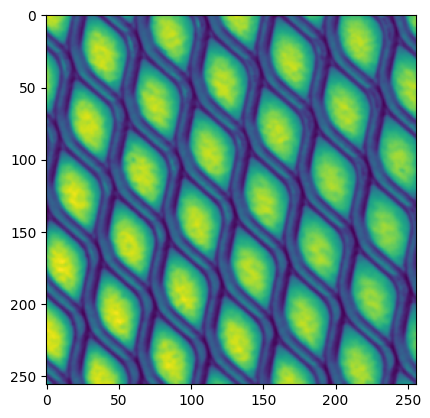

In [8]:
plt.imshow(sample_img[0][0].cpu())

In [9]:
# Models
netG = models.Generator_256(latent_dim=128).to(device)
netD = Discriminator_cnn2(img_shape).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

# print(netG)
# print("Parameter dtype: ",next(netG.parameters()).dtype)
# print("number of parameters in generator: ", sum(p.numel() for p in netG.parameters()), f"| Memory occupied: {sum(p.numel() for p in netG.parameters())/(2**18)} MB")
# print("number of parameters in D: ", sum(p.numel() for p in netD.parameters()),  f"| Memory occupied: {sum(p.numel() for p in netD.parameters())/(2**18)} MB")

# print("Noise shape: ",fixed_noise.shape)
# pred = netG(fixed_noise)
# print("pred shape: ", pred.shape)

# out = netD(sample_img)
# print("out shape: ", out.shape, "Output : ", out[0])
# print(netD)
# exit(0)

loss = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:

D_losses = []
G_losses = []
# img_list = []
#Training Loop
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

        # (1) Update D network: 

        netD.zero_grad()  # refresh the gradient 
        img = data[0].to(device)
        # print("Image shape: ",img.shape)
        b_size = img.size(0) # current batch size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # all ones because training netD with real images
        output = netD(img).view(-1)
        # print("Output_D shape :",output.shape, 'label shape:' , label.shape)
        # exit(0)
        # print(output)
        error_real = loss(output, label)
        error_real.backward()
        # optimizerD.step()
        noise = torch.randn(b_size, noise_dim, 1, 1, device=device)
        # print(noise.shape)
        fake = netG(noise)

        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        error_fake = loss(output, label)
        error_fake.backward()
        error_D = error_fake + error_real # for tracking D error
        optimizerD.step()

        # (2) Update G network: 
        netG.zero_grad()
        label.fill_(real_label)  #  labels are real for generator cost est
        output = netD(fake).view(-1)
        error_G = loss(output, label)
        error_G.backward()
        optimizerG.step()

        if i % 50 ==0:
            print( f"Epoch :{epoch} [{i}/160] LOSSES: G {error_G} | D {error_D}")
        D_losses.append(error_D.item())
        G_losses.append(error_G.item())

    with torch.no_grad():
        pred = netG(fixed_noise).detach().cpu()
    img_save =torchvision.utils.make_grid(fake, padding=2,nrow=4, normalize=True)
    torchvision.utils.save_image(img_save, f"../images/256/img_{epoch}.png")
torch.save(netG.state_dict(), "./gen.pth")
torch.save(netD.state_dict(), "./Des.pth")



Epoch :0 [0/264] LOSSES: G 14.995094299316406 | D 1.950624704360962
Epoch :0 [50/264] LOSSES: G 74.26005554199219 | D 1.1221436598762063e-27
Epoch :0 [100/264] LOSSES: G 74.29170227050781 | D 2.594601987722547e-29
Epoch :0 [150/264] LOSSES: G 75.52930450439453 | D 8.327247300764089e-28
Epoch :1 [0/264] LOSSES: G 73.67008972167969 | D 1.1587524825569723e-28
Epoch :1 [50/264] LOSSES: G 77.19761657714844 | D 1.1659418887614037e-29
Epoch :1 [100/264] LOSSES: G 74.62464904785156 | D 3.976398222698328e-27
Epoch :1 [150/264] LOSSES: G 74.26609802246094 | D 1.0622991424177645e-28
Epoch :2 [0/264] LOSSES: G 76.69577026367188 | D 1.2618933736868218e-29
Epoch :2 [50/264] LOSSES: G 75.57196807861328 | D 1.0038377315488844e-27
Epoch :2 [100/264] LOSSES: G 77.77643585205078 | D 7.450581485102248e-09
Epoch :2 [150/264] LOSSES: G 73.51535034179688 | D 3.2095196892695576e-27
Epoch :3 [0/264] LOSSES: G 74.60770416259766 | D 2.289490147401645e-28
Epoch :3 [50/264] LOSSES: G 75.59913635253906 | D 8.832361

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(np.arange(len(G_losses)), G_losses ,label="G")
plt.plot(np.arange(len(D_losses)), D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("./images/graph.png")